#setup

installing packages that are not preinstall in colab










In [ ]:
%%capture
!pip install transformers
!pip install shap

running utils_fake_news.py taken from Flores and Hao (https://github.com/ljyflores/fake-news-adversarial-benchmark/blob/master/utils_fake_news.py)



In [ ]:
!cp /content/drive/MyDrive/fake-news-adversarial-benchmark/utils_fake_news.py .
%run utils_fake_news.py

importing all neccesary packages and assining gpu to device


In [ ]:
import pickle
import numpy as np
import pandas as pd
import random
from itertools import chain
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import itertools
import heapq

import matplotlib.pyplot as plt
!apt-get install -y fonts-arial-regular
plt.rcParams["font.family"] = "Arial"

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package fonts-arial-regular


defining the file paths

In [ ]:
path='/content/drive/MyDrive/fake-news-adversarial-benchmark/'


"""
# Define paths liar

dataset='LIAR'
model_path = path+'Model/liar_model2'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/liar/'


path_csv= path_data_created+'liar_1000.csv'

shap_path=path_data_created+'shapvalues_1000_liar.sav'
path_labels=path_data_created+'labels_liar.npy'
outputs_path=path_data_created+'original_probs_liar_1000.pt'
"""
# Define paths Fake News

dataset='Fake News'
model_path = path+'Model/fn_model'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/fake_news/'

path_csv= path_data_created+'fake_news_1000.csv'
path_labels=path_data_created+'labels_fake_news.npy'
shap_path=path_data_created+'shapvalues_1000_fake_news.sav'
outputs_path=path_data_created+'original_outputs_fake_news_1000.pt'
"""
# Define paths imdb

dataset='IMDB'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'

path_csv= path_data_created+'imdb_1000.csv'
path_labels=path_data_created+'labels_imdb.npy'

shap_path=path_data_created+'shapvalues_1000_imdb.sav'
outputs_path=path_data_created+'original_probs_imdb_1000.pt'

"""



"\n# Define paths imdb\n\ndataset='IMDB'\npath_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'\n\npath_csv= path_data_created+'imdb_1000.csv'\npath_labels=path_data_created+'labels_imdb.npy'\n\nshap_path=path_data_created+'shapvalues_1000_imdb.sav' \noutputs_path=path_data_created+'original_probs_imdb_1000.pt'\n\n"

Load the tokenizer and model

In [ ]:


if dataset == 'IMDB':
  print('Using IMDB trained model and Tokenizer')
  !pip install textattack
  from transformers import AutoModelForSequenceClassification, AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
  model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-imdb")
else:
  print('Using '+str(model_path)+' model')
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  model = BertForSequenceClassification.from_pretrained(model_path,  num_labels = 2)



Using /content/drive/MyDrive/fake-news-adversarial-benchmark/Model/fn_model model


loading the dataframe, the labels, the shap values and the original probabilities

In [ ]:
path_final=path+'final_files/'+dataset+'/'
df = pd.read_csv(path_csv)
labels = np.load(path_labels)

shap_values = pickle.load(open(shap_path, 'rb'))
original_probs= torch.load(outputs_path, map_location=torch.device('cpu'))

labels=torch.LongTensor(labels)

In [ ]:
shap_values.data[:5]

(array(['', ' gay', 's', ' against', ' sha', 'ria', ' march', ' branded',
        " '", ' islam', 'op', 'ho', 'bic', " '", ' ,', ' will', ' be',
        ' picket', 'ed', ' by', ' lgbt', ' activists', ''], dtype=object),
 array(['', ' for', ' trump', " '", ' s', ' nominees', ' ,', ' a',
        ' billionaire', 's', " '", ' guide', ' to', ' running', ' the',
        ' government', ' -', ' the', ' new', ' york', ' times', ''],
       dtype=object),
 array(['', ' morley', ' safer', ' ,', ' main', 'sta', 'y', ' of', ' ‘',
        ' 60', ' minutes', ' ,', " '", ' is', ' dead', ' at', ' 84', ' -',
        ' the', ' new', ' york', ' times', ''], dtype=object),
 array(['', ' a', ' tough', ' sell', ' ,', ' even', ' in', ' russia', ' :',
        ' ivan', ' the', ' not', ' -', ' so', ' -', ' terrible', ' -',
        ' the', ' new', ' york', ' times', ''], dtype=object),
 array(['', ' 5', ' .', ' 4', ' -', ' magnitude', ' earthquake', ' jolt',
        's', ' central', ' italy', ''], dtype=object))

In [ ]:
df.head(10)

,Unnamed: 0,id,statement,label
0,3315,3410,gays against sharia march branded 'islamophobi...,0
1,19546,20089,"for trump's nominees, a billionaires' guide to...",0
2,12134,12473,"morley safer, mainstay of ‘60 minutes,' is dea...",0
3,2150,2208,"a tough sell, even in russia: ivan the not-so-...",0
4,7998,8217,5.4-magnitude earthquake jolts central italy,1
5,17274,17742,what is lost by burying the trans-pacific part...,0
6,8698,8946,watching paralyzed musicians play music with t...,1
7,8145,8371,"raising 2 young children by herself, in a spac...",0
8,8028,8249,us intelligence warns public of pre-election d...,1
9,17973,18460,mail's giant map of britain to include names a...,1


#definitions

In [ ]:
def encode_df(data, tokenizer, labels):
    data = data.fillna("")
    bert_encoded_dict = data.apply(lambda x: tokenizer.encode_plus("".join(x).lstrip().replace(" .", ".").replace(" , ", ", "),
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      max_length = 120,           # Pad & truncate all sentences.
                      padding='max_length',
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                      truncation = True
                      ),axis=1)
    bert_input_ids = torch.cat([item['input_ids'] for item in bert_encoded_dict], dim=0)
    bert_attention_masks = torch.cat([item['attention_mask'] for item in bert_encoded_dict], dim=0)
    # Format targets
    labels = torch.tensor(labels)
    return {'input_ids':bert_input_ids, 'attention_masks':bert_attention_masks, 'labels':labels}


#get_global_feature_list
#based on suggestions from https://github.com/slundberg/shap/issues/632
def get_global_feature_list(shap_values):
    data = list(chain.from_iterable(shap_values.data))
    values = list(chain.from_iterable(shap_values.values))
    df = pd.DataFrame({'data': data, 'values': values})
    df['values'] = abs(df['values'])
    df_grouped = df.groupby('data', as_index=False).mean().sort_values('values',ascending=False)
    return df_grouped

#deletion and preservation check implementation based on https://github.com/Jianbo-Lab/L2X/tree/master/imdb-sent
def replace_global_highest_elements(shap_values, k, tokenizer, labels, replacement_type):
    global_features = get_global_feature_list(shap_values)
    # gets the features/words from the shap value object
    data = pd.DataFrame(shap_values.data)
    data_rand=data.copy()
    if replacement_type == "top":
        # takes the top k% of the global features or random
        replacement_features = global_features.head(int(len(global_features)*k))
        replacement_features_rand = global_features['data'].sample(frac=k)

    elif replacement_type == "bottom":
        # takes the bottom 100-k% of the global features or random
        replacement_features = global_features.tail(int(len(global_features)*(1-k)))
        replacement_features_rand = global_features['data'].sample(frac=(1-k))

    data = data.where(~data.isin(replacement_features["data"].tolist()), "[PAD]")
    data_rand = data_rand.where(~data_rand.isin(replacement_features_rand.tolist()), "[PAD]")
    en_replaced=encode_df(data, tokenizer, labels)
    en_rand=encode_df(data_rand, tokenizer, labels)
    return en_replaced, en_rand

def replace_k_highest_random_elements(shap_values, k, tokenizer, labels, replacement_type):
    print('replace_local')
    replaced_selected=[]; replaced_rand=[]
    for i in range(len(shap_values.values)):
      if i==10:
        print('k before if: '+str(k))
      if len(shap_values.values[i]) < k:
        lk=len(shap_values.values[i])
        ind_high= (np.argsort(np.abs(shap_values.values[i]))[::-1]) [:lk]
        ind_rand = random.sample(range(len(shap_values.values[i])), lk)
      else:
        #replace hightest
        ind_high= (np.argsort(np.abs(shap_values.values[i]))[::-1]) [:k]
        ind_rand = random.sample(range(len(shap_values.values[i])), k)
      l= shap_values.data[i]
      if replacement_type=='top':
        selected = ["[PAD]" if np.isin(i, ind_high) else x for i, x in enumerate(l)]
        rand = ["[PAD]" if np.isin(i, ind_rand) else x for i, x in enumerate(l)]

      elif replacement_type=='bottom':
        selected = ["[PAD]" if not np.isin(i, ind_high) else x for i, x in enumerate(l)]
        rand = ["[PAD]" if not np.isin(i, ind_rand) else x for i, x in enumerate(l)]
        if i==10:
          print('k after if: '+str(k))
          #print(selected)
          #print('ind_high:'+str(ind_high))
          print('ind_high:'+str(len(ind_high)))

      replaced_selected.append(selected)
      replaced_rand.append(rand)

    data=pd.DataFrame(replaced_selected); data_rand=pd.DataFrame(replaced_rand)
    en_replaced= encode_df(data, tokenizer, labels)
    en_rand= encode_df(data_rand, tokenizer, labels)
    return en_replaced, en_rand

def compute_acc_and_lor(shap_values, labels, k, tokenizer, model, original_prob, device, replacement_area, replacement_type):
    metrics = pd.DataFrame(columns=['acc_selected', 'flip_selected', 'lor_change_selected', 'apoc_selected',
    'acc_rand', 'flip_rand', 'lor_change_rand', 'apoc_rand'])
    print('k in compute:'+str(k))
    if replacement_area == 'global':
        en_replaced, en_rand = replace_global_highest_elements(shap_values,
            k, tokenizer, labels, replacement_type)
    elif replacement_area =='local':
        en_replaced, en_rand = replace_k_highest_random_elements(shap_values,
            k, tokenizer, labels, replacement_type=replacement_type)

    with torch.no_grad():
      model.to(device)
      p_selected = model(en_replaced['input_ids'].to(device),
                         attention_mask=en_replaced['attention_masks'].to(device), labels=en_replaced['labels'].to(device))
      p_rand = model(en_rand['input_ids'].to(device),
                     attention_mask=en_rand['attention_masks'].to(device), labels=en_rand['labels'].to(device))
#https://github.com/icrto/xML/issues/1
    probs_selected=F.softmax(p_selected.logits, dim=1)
    probs_rand=F.softmax(p_rand.logits, dim=1)
    probs_original= F.softmax(original_prob, dim=1)

    for i in range(len(shap_values.values)):
        x_selected = probs_selected[i].cpu(); prob = probs_original[i].cpu()
        x_rand = probs_rand[i].cpu()
        label = labels[i].cpu()
        cls = np.argmax(prob)
        acc_selected = torch.eq(label, torch.argmax(x_selected))
        flip_selected = np.argmax(prob)==np.argmax(x_selected)
        #lor based on https://github.com/Jianbo-Lab/LCShapley/blob/master/texts/utils.py
        lor_change_selected = compute_lor(x_selected, cls) - compute_lor(prob, cls)
        aopc_selected = AOPC(prob, x_selected, cls)
        acc_rand = torch.eq(label, torch.argmax(x_rand))
        flip_rand = np.argmax(prob)==np.argmax(x_rand)
        lor_change_rand = compute_lor(x_rand, cls) - compute_lor(prob, cls)
        aopc_rand = AOPC(prob, x_rand, cls)
        metrics = metrics.append({'acc_selected':acc_selected,'flip_selected':flip_selected, 'lor_change_selected':lor_change_selected, 'aopc_selected':aopc_selected, 'acc_rand':acc_rand, 'flip_rand':flip_rand, 'lor_change_rand':lor_change_rand, 'aopc_rand':aopc_rand}, ignore_index=True)

    avg_acc_selected = np.mean(metrics['acc_selected'].astype(float).values)
    avg_flip_selected = np.mean(metrics['flip_selected'].astype(float).values)
    avg_lor_selected = metrics['lor_change_selected'].mean()
    avg_aopc_selected = metrics['aopc_selected'].mean()
    avg_acc_rand = np.mean(metrics['acc_rand'].astype(float).values)
    avg_flip_rand = np.mean(metrics['flip_rand'].astype(float).values)
    avg_lor_rand = metrics['lor_change_rand'].mean()
    avg_aopc_rand = np.mean(metrics['aopc_rand'].astype(float).values)
    return_metrics ={'k':k, 'acc_selected':avg_acc_selected,'flip_selected':avg_flip_selected,
    'lor_change_selected':avg_lor_selected,'aopc_selected':avg_aopc_selected, 'acc_rand':avg_acc_rand, 'flip_rand':avg_flip_rand,
    'lor_change_rand':avg_lor_rand, 'aopc_rand':avg_aopc_rand}
    return return_metrics

def replace_and_get_accuracy_flip_lor(shap_values, tokenizer, model, labels, original_prob, device, replacement_area, replacement_type,  k_range = np.arange(0, 0.21, 0.01)):
  accuracy_df=pd.DataFrame(columns =['k', 'acc_selected', 'flip_selected', 'lor_change_selected', 'aopc_selected', 'acc_rand', 'flip_rand', 'lor_change_rand', 'aopc_rand'])
  for k in k_range:
    print('k in replace:'+str(k))
    accuracy_df = accuracy_df.append(pd.DataFrame.from_dict(compute_acc_and_lor(shap_values, labels, k, tokenizer, model, original_prob, device, replacement_area, replacement_type), orient='index').transpose())
  return accuracy_df

def compute_lor(prob, cls):
	return np.log(prob[cls] + 1e-6) - np.log(1 - prob[cls] + 1e-6)

def AOPC(original_probs, modified_probs, cls):
    return (original_probs[cls]-modified_probs[cls]).item()


In [ ]:
import matplotlib.pyplot as plt

def line_plot_template( y, z,  ylabel, legend, filename, title, xlabel, x,):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, color='blue', marker='o')
    plt.plot(x, z, color='red', marker='o')
    plt.rcParams["font.family"] = "Arial"
    plt.title(title)
    plt.xlabel("k", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(legend, fontsize=14)
    plt.grid(visible=True, which='both', axis='both', linestyle='--', color='grey')
    plt.savefig((path_final+filename), dpi=300, bbox_inches='tight')
    plt.show()


#metrics

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report = classification_report(labels, torch.argmax(original_probs, axis=1), output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_latex(path_data_created+dataset+'_report.tex')

In [ ]:
#average statement token length
length_tokens=[]
for i in range(len(shap_values.data)):
  length_tokens.append(len(shap_values.data[i]))
np.mean(length_tokens)

18.669

In [ ]:
#numbers of unique tokens
global_list = get_global_feature_list(shap_values)
#numbers of total tokens
doubles_list = data = list(chain.from_iterable(shap_values.data))
#distribution of labels
print(np.mean(labels.numpy()))

0.505


In [ ]:
df_description = pd.DataFrame({'Unique Tokens': [len(global_list)],
                  'Total Tokens': [len(doubles_list)],
                    'Avg Token per Statement': [np.mean(length_tokens)],
                  'Label Distribution': [np.mean(labels.numpy())]})
df_description.to_latex(path_data_created+dataset+'_token.tex')


In [ ]:
df_description

,Unique Tokens,Total Tokens,Avg Token per Statement,Label Distribution
0,4517,18669,18.669,0.505


In [ ]:
np.random.seed(42)
rand_index= np.random.randint(0, high=1000, size=5)
sample = df.loc[rand_index].copy()
with pd.option_context("max_colwidth", 1000):
    print (sample.to_latex(path_data_created+dataset+'_sample.tex'))



None


#incremental deletion

In [ ]:
df_inc= replace_and_get_accuracy_flip_lor(shap_values, tokenizer, model, labels, original_probs, device, 'global', 'top',  k_range = np.arange(0, 1.01, 0.05))
df_inc.to_csv(path_final+dataset+'_inc.csv')

k in replace:0.0
k in compute:0.0


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


k in replace:0.05
k in compute:0.05
k in replace:0.1
k in compute:0.1
k in replace:0.15000000000000002
k in compute:0.15000000000000002
k in replace:0.2
k in compute:0.2
k in replace:0.25
k in compute:0.25
k in replace:0.30000000000000004
k in compute:0.30000000000000004
k in replace:0.35000000000000003
k in compute:0.35000000000000003
k in replace:0.4
k in compute:0.4
k in replace:0.45
k in compute:0.45
k in replace:0.5
k in compute:0.5
k in replace:0.55
k in compute:0.55
k in replace:0.6000000000000001
k in compute:0.6000000000000001
k in replace:0.65
k in compute:0.65
k in replace:0.7000000000000001
k in compute:0.7000000000000001
k in replace:0.75
k in compute:0.75
k in replace:0.8
k in compute:0.8
k in replace:0.8500000000000001
k in compute:0.8500000000000001
k in replace:0.9
k in compute:0.9
k in replace:0.9500000000000001
k in compute:0.9500000000000001
k in replace:1.0
k in compute:1.0


In [ ]:
df_inc

,k,acc_selected,flip_selected,lor_change_selected,aopc_selected,acc_rand,flip_rand,lor_change_rand,aopc_rand
0,0.00,0.561,1.000,-0.003926,0.000029,0.561,1.000,-0.003926,0.000029
0,0.05,0.576,0.959,-0.381847,0.034749,0.562,0.947,-0.381131,0.041604
0,0.10,0.564,0.923,-0.719097,0.067844,0.560,0.849,-1.225682,0.128162
0,0.15,0.568,0.865,-1.374643,0.122091,0.555,0.796,-1.918758,0.180847
0,0.20,0.565,0.818,-1.868447,0.164692,0.553,0.734,-2.910556,0.243564
0,0.25,0.558,0.745,-2.766454,0.233559,0.547,0.702,-3.334371,0.275452
0,0.30,0.557,0.652,-4.005462,0.325185,0.568,0.675,-3.600136,0.298901
0,0.35,0.548,0.579,-5.015109,0.395700,0.574,0.569,-5.175222,0.405934
0,0.40,0.554,0.511,-5.920344,0.461597,0.548,0.589,-4.839878,0.385080
0,0.45,0.529,0.494,-6.328848,0.481544,0.534,0.515,-6.070630,0.462006


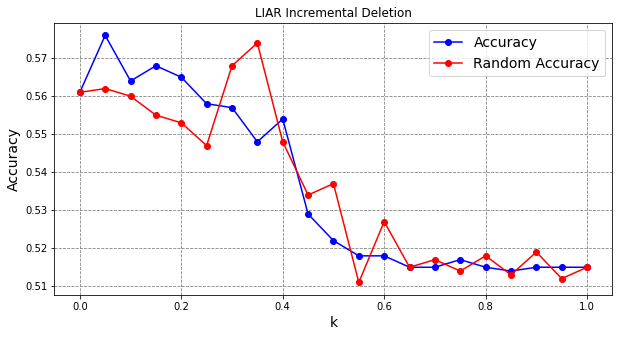

In [ ]:
test='inc'
plot_name=(dataset + ' Incremental Deletion')
df=df_inc
line_plot_template(df['acc_selected'],  df['acc_rand'],  'Accuracy', ["Accuracy", "Random Accuracy"], (test+"_plot_acc.png") , plot_name, 'k', df_inc['k'])


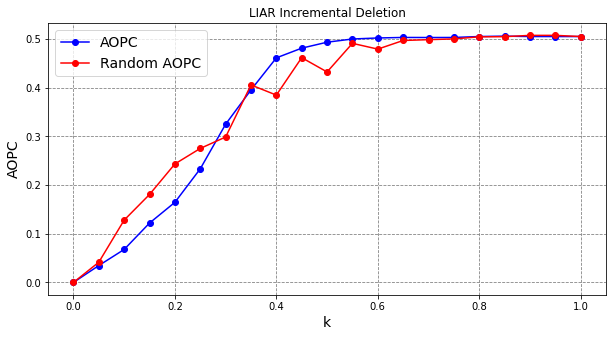

In [ ]:
line_plot_template(df['aopc_selected'],  df['aopc_rand'],  'AOPC', ["AOPC", "Random AOPC"], (dataset+'_'+test+"_plot_aopc.png"), plot_name, 'k', df_inc['k'])

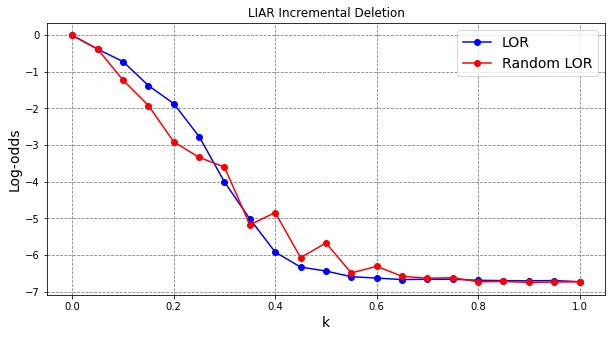

In [ ]:
line_plot_template(df['lor_change_selected'],  df['lor_change_rand'],  'Log-odds', ["LOR", "Random LOR"], (dataset+'_'+test+"_plot_lor.png"), plot_name, 'k', df_inc['k'])

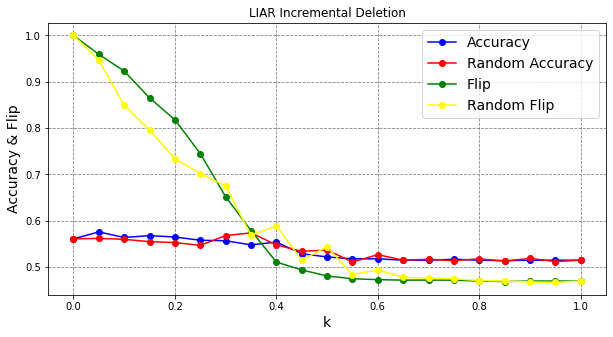

In [ ]:
y=df['acc_selected']; z= df['acc_rand']; ylabel= 'Accuracy';  title= plot_name; xlabel= 'k'; x=df['k']
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='blue', marker='o')
plt.plot(x, z, color='red', marker='o')
plt.plot(x, df['flip_selected'], color='green', marker='o')
plt.plot(x, df['flip_rand'], color='yellow', marker='o')
plt.rcParams["font.family"] = "Arial"
plt.title(title)
plt.xlabel("k", fontsize=14)
plt.ylabel("Accuracy & Flip", fontsize=14)
plt.legend(["Accuracy", "Random Accuracy", "Flip", "Random Flip"], fontsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', color='grey')
plt.savefig((path_final+dataset+test+"_plot_flip.png"), dpi=300, bbox_inches='tight')
plt.show()



#incremental addition

In [ ]:
df_inc_add= replace_and_get_accuracy_flip_lor(shap_values, tokenizer, model, labels, original_probs, device, 'global', 'bottom',  k_range = np.arange(0, 1.01, 0.05))
df_inc_add.to_csv(path_final+dataset+'_inc_add.csv')

k in replace:0.0
k in compute:0.0


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


k in replace:0.05
k in compute:0.05
k in replace:0.1
k in compute:0.1
k in replace:0.15000000000000002
k in compute:0.15000000000000002
k in replace:0.2
k in compute:0.2
k in replace:0.25
k in compute:0.25
k in replace:0.30000000000000004
k in compute:0.30000000000000004
k in replace:0.35000000000000003
k in compute:0.35000000000000003
k in replace:0.4
k in compute:0.4
k in replace:0.45
k in compute:0.45
k in replace:0.5
k in compute:0.5
k in replace:0.55
k in compute:0.55
k in replace:0.6000000000000001
k in compute:0.6000000000000001
k in replace:0.65
k in compute:0.65
k in replace:0.7000000000000001
k in compute:0.7000000000000001
k in replace:0.75
k in compute:0.75
k in replace:0.8
k in compute:0.8
k in replace:0.8500000000000001
k in compute:0.8500000000000001
k in replace:0.9
k in compute:0.9
k in replace:0.9500000000000001
k in compute:0.9500000000000001
k in replace:1.0
k in compute:1.0


In [ ]:
df_inc_add.to_csv(path_final+dataset+'_inc_add.csv')

In [ ]:
df_inc_add

,k,acc_selected,flip_selected,lor_change_selected,aopc_selected,acc_rand,flip_rand,lor_change_rand,aopc_rand
0,0.0,0.512,0.506,-7.039971e+00,4.751143e-01,0.512,0.506,-7.039971e+00,4.751143e-01
0,0.1,0.642,0.642,-5.597744e+00,3.427301e-01,0.512,0.506,-6.935538e+00,4.705300e-01
0,0.2,0.741,0.747,-4.189470e+00,2.372037e-01,0.521,0.515,-6.715696e+00,4.572584e-01
0,0.3,0.798,0.818,-2.816937e+00,1.728024e-01,0.556,0.554,-6.019290e+00,4.168167e-01
0,0.4,0.857,0.895,-1.171190e+00,8.938811e-02,0.596,0.596,-5.431291e+00,3.784518e-01
0,0.5,0.868,0.936,-4.982741e-01,4.671369e-02,0.665,0.657,-4.830162e+00,3.234747e-01
0,0.6,0.887,0.973,-1.603023e-01,1.612601e-02,0.699,0.713,-4.135588e+00,2.666822e-01
0,0.7,0.887,0.979,-1.031486e-01,9.990998e-03,0.795,0.815,-2.535973e+00,1.673310e-01
0,0.8,0.889,0.993,-5.920336e-02,4.871797e-03,0.852,0.912,-1.007149e+00,7.427209e-02
0,0.9,0.887,0.997,-1.829287e-02,2.888043e-03,0.879,0.945,-5.648040e-01,4.383386e-02


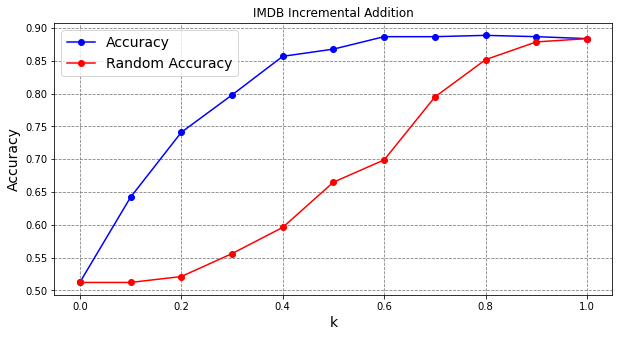

In [ ]:
test='inc_add'
plot_name=(dataset +' Incremental Addition')
df=df_inc_add
line_plot_template(df['acc_selected'],  df['acc_rand'],  'Accuracy', ["Accuracy", "Random Accuracy"], (test+"_plot_acc.png") , plot_name, 'k', df['k'])


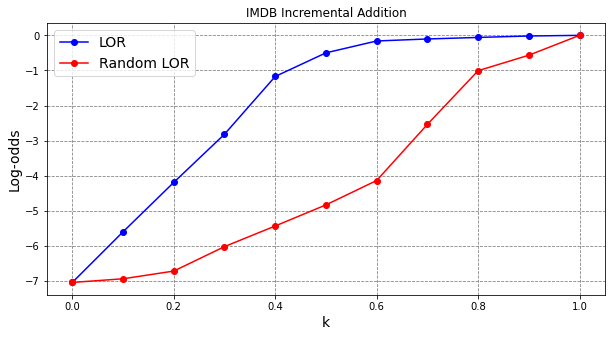

In [ ]:


line_plot_template(df['lor_change_selected'],  df['lor_change_rand'],  'Log-odds', ["LOR", "Random LOR"], (test+"_plot_lor.png"), plot_name, 'k', df['k'])

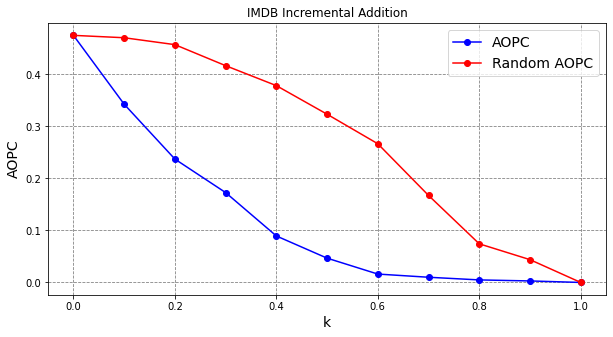

In [ ]:
line_plot_template(df['aopc_selected'],  df['aopc_rand'],  'AOPC', ["AOPC", "Random AOPC"], (test+"_plot_aopc.png"), plot_name, 'k', df['k'])

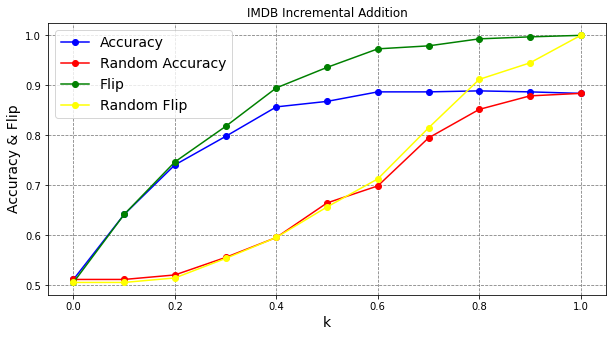

In [ ]:
y=df['acc_selected']; z= df['acc_rand']; ylabel= 'Accuracy';  title= plot_name; xlabel= 'k'; x=df['k']
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='blue', marker='o')
plt.plot(x, z, color='red', marker='o')
plt.plot(x, df['flip_selected'], color='green', marker='o')
plt.plot(x, df['flip_rand'], color='yellow', marker='o')
plt.rcParams["font.family"] = "Arial"
plt.title(title)
plt.xlabel("k", fontsize=14)
plt.ylabel("Accuracy & Flip", fontsize=14)
plt.legend(["Accuracy", "Random Accuracy", "Flip", "Random Flip"], fontsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', color='grey')
plt.savefig((path_final+dataset+test+"_plot_flip.png"), dpi=300, bbox_inches='tight')
plt.show()



#deletion check

In [ ]:
df_del= replace_and_get_accuracy_flip_lor(shap_values, tokenizer, model, labels, original_probs, device, 'local', 'top',
                                           k_range = np.arange(0, 15,1))
df_del.to_csv(path_final+dataset+'_del.csv')

k in replace:0
k in compute:0
replace_local
k before if: 0


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


k in replace:1
k in compute:1
replace_local
k before if: 1
k in replace:2
k in compute:2
replace_local
k before if: 2
k in replace:3
k in compute:3
replace_local
k before if: 3
k in replace:4
k in compute:4
replace_local
k before if: 4
k in replace:5
k in compute:5
replace_local
k before if: 5
k in replace:6
k in compute:6
replace_local
k before if: 6
k in replace:7
k in compute:7
replace_local
k before if: 7
k in replace:8
k in compute:8
replace_local
k before if: 8
k in replace:9
k in compute:9
replace_local
k before if: 9
k in replace:10
k in compute:10
replace_local
k before if: 10
k in replace:11
k in compute:11
replace_local
k before if: 11
k in replace:12
k in compute:12
replace_local
k before if: 12
k in replace:13
k in compute:13
replace_local
k before if: 13
k in replace:14
k in compute:14
replace_local
k before if: 14


In [ ]:
df_del

,k,acc_selected,flip_selected,lor_change_selected,aopc_selected,acc_rand,flip_rand,lor_change_rand,aopc_rand
0,0.0,0.884,1.000,1.643896e-07,1.788139e-10,0.884,1.000,1.643896e-07,1.788139e-10
0,1.0,0.862,0.962,-4.828333e-01,3.600551e-02,0.883,0.993,-1.439183e-04,2.085306e-03
0,2.0,0.856,0.950,-7.208566e-01,4.830492e-02,0.883,0.989,-3.555162e-02,4.845767e-03
0,3.0,0.852,0.942,-8.826950e-01,5.300836e-02,0.882,0.990,-7.989034e-02,6.163713e-03
0,4.0,0.843,0.935,-1.048153e+00,6.231044e-02,0.887,0.983,-7.292806e-02,8.148269e-03
0,5.0,0.834,0.920,-1.218749e+00,7.547833e-02,0.884,0.982,-8.627008e-02,8.566473e-03
0,6.0,0.832,0.912,-1.358259e+00,8.194798e-02,0.894,0.976,-1.247897e-01,1.348356e-02
0,7.0,0.828,0.908,-1.465302e+00,8.497884e-02,0.883,0.983,-1.205530e-01,1.020807e-02
0,8.0,0.830,0.906,-1.586947e+00,9.091719e-02,0.881,0.971,-1.843251e-01,1.811134e-02
0,9.0,0.828,0.898,-1.673902e+00,9.667047e-02,0.881,0.969,-1.889569e-01,2.067366e-02


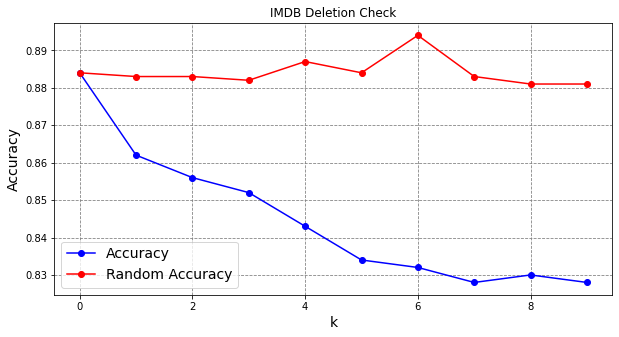

In [ ]:
test='del'
plot_name=(dataset +' Deletion Check')
df=df_del
line_plot_template(df['acc_selected'],  df['acc_rand'],  'Accuracy', ["Accuracy", "Random Accuracy"], (test+dataset+"_plot_acc.png") , plot_name, 'k', df['k'])


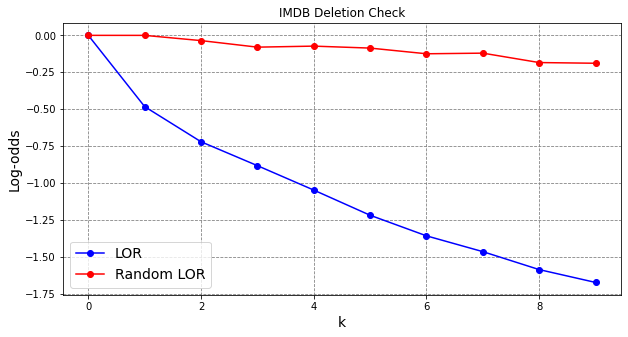

In [ ]:
line_plot_template(df['lor_change_selected'],  df['lor_change_rand'],  'Log-odds', ["LOR", "Random LOR"], (test+dataset+"_plot_lor.png"), plot_name, 'k', df['k'])

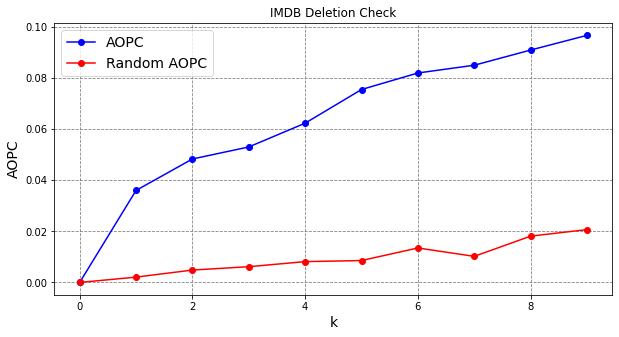

In [ ]:
line_plot_template(df['aopc_selected'],  df['aopc_rand'],  'AOPC', ["AOPC", "Random AOPC"], (test+dataset+"_plot_aopc.png"), plot_name, 'k', df['k'])

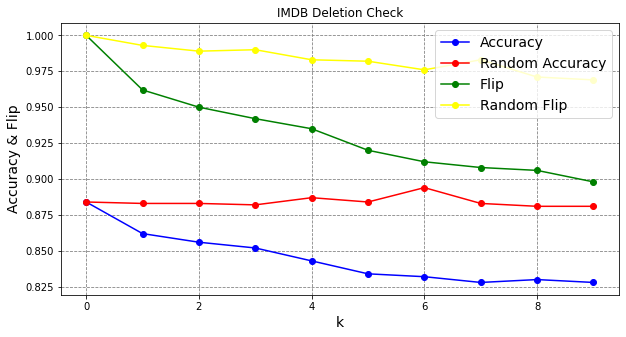

In [ ]:
y=df['acc_selected']; z= df['acc_rand']; ylabel= 'Accuracy';  title= plot_name; xlabel= 'k'; x=df['k']
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='blue', marker='o')
plt.plot(x, z, color='red', marker='o')
plt.plot(x, df['flip_selected'], color='green', marker='o')
plt.plot(x, df['flip_rand'], color='yellow', marker='o')
plt.rcParams["font.family"] = "Arial"
plt.title(title)
plt.xlabel("k", fontsize=14)
plt.ylabel("Accuracy & Flip", fontsize=14)
plt.legend(["Accuracy", "Random Accuracy", "Flip", "Random Flip"], fontsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', color='grey')
plt.savefig((path_final+dataset+test+"_plot_flip.png"), dpi=300, bbox_inches='tight')
plt.show()

#preservation check

In [ ]:
df_pres= replace_and_get_accuracy_flip_lor(shap_values, tokenizer, model, labels, original_probs, device, 'local', 'bottom',
                                           k_range = np.arange(0, 15,1))


df_pres.to_csv(path_final+dataset+'_pres.csv')

k in replace:0
k in compute:0
replace_local
k before if: 0
k after if: 0
ind_high:0


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


k in replace:1
k in compute:1
replace_local
k before if: 1
k after if: 1
ind_high:1
k in replace:2
k in compute:2
replace_local
k before if: 2
k after if: 2
ind_high:2
k in replace:3
k in compute:3
replace_local
k before if: 3
k after if: 3
ind_high:3
k in replace:4
k in compute:4
replace_local
k before if: 4
k after if: 4
ind_high:4
k in replace:5
k in compute:5
replace_local
k before if: 5
k after if: 5
ind_high:5
k in replace:6
k in compute:6
replace_local
k before if: 6
k after if: 6
ind_high:6
k in replace:7
k in compute:7
replace_local
k before if: 7
k after if: 7
ind_high:7
k in replace:8
k in compute:8
replace_local
k before if: 8
k after if: 8
ind_high:8
k in replace:9
k in compute:9
replace_local
k before if: 9
k after if: 9
ind_high:9
k in replace:10
k in compute:10
replace_local
k before if: 10
k after if: 10
ind_high:10
k in replace:11
k in compute:11
replace_local
k before if: 11
k after if: 11
ind_high:11
k in replace:12
k in compute:12
replace_local
k before if: 12
k af

In [ ]:
df_pres

In [ ]:
test='pres'
plot_name=(dataset +' Preservation Check')
df=df_pres
line_plot_template(df['acc_selected'],  df['acc_rand'],  'Accuracy', ["Accuracy", "Random Accuracy"], (test+dataset+"_plot_acc.png") , plot_name, 'k', df['k'])


In [ ]:
line_plot_template(df['lor_change_selected'],  df['lor_change_rand'],  'Log-odds', ["LOR", "Random LOR"], (test+dataset+"_plot_lor.png"), plot_name, 'k', df['k'])

In [ ]:
line_plot_template(df['aopc_selected'],  df['aopc_rand'],  'AOPC', ["AOPC", "Random AOPC"], (test+dataset+"_plot_aopc.png"), plot_name, 'k', df['k'])

In [ ]:
y=df['acc_selected']; z= df['acc_rand']; ylabel= 'Accuracy';  title= plot_name; xlabel= 'k'; x=df['k']
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='blue', marker='o')
plt.plot(x, z, color='red', marker='o')
plt.plot(x, df['flip_selected'], color='green', marker='o')
plt.plot(x, df['flip_rand'], color='yellow', marker='o')
plt.rcParams["font.family"] = "Arial"
plt.title(title)
plt.xlabel("k", fontsize=14)
plt.ylabel("Accuracy & Flip", fontsize=14)
plt.legend(["Accuracy", "Random Accuracy", "Flip", "Random Flip"], fontsize=14)
plt.grid(visible=True, which='both', axis='both', linestyle='--', color='grey')
plt.savefig((path_final+dataset+test+"_plot_flip.png"), dpi=300, bbox_inches='tight')
plt.show()